A short tutorial for analyzing a [Design of Experiments](https://en.wikipedia.org/wiki/Design_of_experiments) using the [statmodels](https://www.statsmodels.org/stable/index.html) python library.

For this example, I'm going to use the dataset: [CAT/TEMP/PRES/CONC EFFECT ON CHEMICAL PROCESS CONVERSION YIELD
BOX, HUNTER & HUNTER (1978)](https://www.itl.nist.gov/div898/education/dex/boxchem.dat), which is available on the [NIST](https://www.itl.nist.gov/div898/education/datasets.htm) website.

In [1]:
import numpy as np
import pandas as pd
from prettypandas import PrettyPandas
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from IPython.display import display, Markdown, HTML

%matplotlib inline
PlotWidth = 6

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Files

columns = ['trial', 'lh', 'ps', 'id', 'rw', 'wt', 'cost', 'time', 'quality', 'comment']
swx1DoE = pd.read_csv('https://raw.githubusercontent.com/wilsongis/3DP_Experiments/main/Data/swx1-doe-schedule.csv', skiprows=1, sep=',', names=columns, index_col=False)

In [3]:
# helper functions for this notebook

# use SVG for matplotlib-based figures
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def coded_to_actual(coded_data, actual_lows, actual_highs):
    """Converts a pandas DataFrame from coded units to actuals."""
    actual_data = coded_data.copy()
    for col in actual_data.columns:
        if not (col in actual_highs and col in actual_lows):
            continue
        try:
            # convert continuous variables to their actual value
            actual_data[col] *= 0.5 * (float(actual_highs[col]) - float(actual_lows[col]))
            # don't need to cast to float here, if either are not a float exception will have been thrown
            actual_data[col] += 0.5 * (actual_highs[col] + actual_lows[col])
        except ValueError:
            # assume 2 level categorical
            actual_data[col] = actual_data[col].map({-1: actual_lows[col], 1: actual_highs[col]})
    return actual_data
        
def get_tick_labels(key, lows, highs, units):
    """Returns a list of low/high labels with units (e.g. [8mm, 10mm])"""
    return [str(lows[key]) + units[key], str(highs[key]) + units[key]]

In [4]:
# Layer Thickness = lh
lh_low = .16 
lh_hi = .24 

# Print Speed = ps
ps_low = 60 
ps_hi = 72 

# Infill Density = id
id_low = .25 
id_hi = .15 

# Raster Width = rw
rw_low = .4 
rw_hi = .8 

# Wall Thicknessv = wt
wt_low = 1.2 
wt_hi = .8

In [5]:
# set some variables related to the coffee data set
actual_lows = { 'lh' : lh_low, 'ps' : ps_low, 'id': id_low, 'rw': rw_low, 'wt': wt_low }
actual_highs = { 'lh' : lh_hi, 'ps' : ps_hi, 'id': id_hi, 'rw': rw_hi, 'wt': wt_hi }
units = { 'lh' : 'mm', 'ps' : 'mm/s', 'id': '%', 'rw': 'mm', 'wt': 'mm' }

Unfortunately the data aren't in a _super_ convenient format for importing or data analysis, so we need to do some work to get the data into a pandas dataframe.

In [6]:

display(swx1DoE)

,trial,lh,ps,id,rw,wt,cost,time,quality,comment
0,1,-1,-1,-1,-1,1,0.60,8981.00,1,NaN
1,2,1,-1,-1,-1,-1,0.56,16885.00,1,NaN
2,3,-1,1,-1,-1,-1,0.60,12788.00,1,NaN
3,4,1,1,-1,-1,1,0.57,9708.00,1,NaN
4,5,-1,-1,1,-1,-1,0.59,14655.00,1,NaN
5,6,1,-1,1,-1,1,0.55,10023.00,1,NaN
6,7,-1,1,1,-1,1,0.54,14549.00,1,NaN
7,8,1,1,1,-1,-1,0.59,7760.00,1,NaN
8,9,-1,-1,-1,1,-1,0.60,14623.00,1,NaN
9,10,1,-1,-1,1,1,0.62,9447.00,1,NaN


This is a perfectly valid format to work up the DoE, but it's also nice to be able to assign numeric values to the factors, rather than the -1/+1 notation.

In [7]:
swx1DoE_actual = coded_to_actual(swx1DoE, actual_lows, actual_highs)

display(Markdown("Actual ## 2<sup>(5-1)</sup> Factorial Design"))
display(PrettyPandas(swx1DoE_actual))

Actual ## 2<sup>(5-1)</sup> Factorial Design

,trial,lh,ps,id,rw,wt,cost,time,quality,comment
0,1,0.160000,60.000000,0.250000,0.400000,0.800000,0.600000,8981.000000,1,nan
1,2,0.240000,60.000000,0.250000,0.400000,1.200000,0.560000,16885.000000,1,nan
2,3,0.160000,72.000000,0.250000,0.400000,1.200000,0.600000,12788.000000,1,nan
3,4,0.240000,72.000000,0.250000,0.400000,0.800000,0.570000,9708.000000,1,nan
4,5,0.160000,60.000000,0.150000,0.400000,1.200000,0.590000,14655.000000,1,nan
5,6,0.240000,60.000000,0.150000,0.400000,0.800000,0.550000,10023.000000,1,nan
6,7,0.160000,72.000000,0.150000,0.400000,0.800000,0.540000,14549.000000,1,nan
7,8,0.240000,72.000000,0.150000,0.400000,1.200000,0.590000,7760.000000,1,nan
8,9,0.160000,60.000000,0.250000,0.800000,1.200000,0.600000,14623.000000,1,nan
9,10,0.240000,60.000000,0.250000,0.800000,0.800000,0.620000,9447.000000,1,nan


Before getting too much into modeling, it's good to visualize the data to see what's going on. We'll start with 3 plots for the response:
* Histogram
* Box Plot
* Line Plot vs. trial

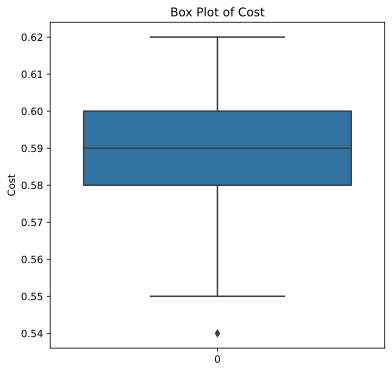

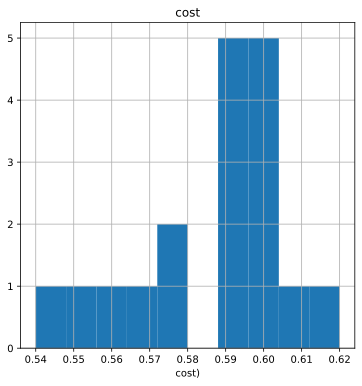

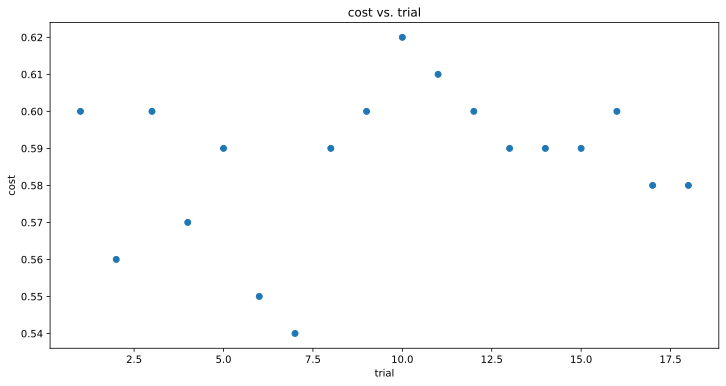

In [8]:
plt.figure(figsize=(PlotWidth, PlotWidth))
sns.boxplot(data=swx1DoE_actual['cost'])
plt.title('Box Plot of Cost')
plt.ylabel('Cost')
plt.show()

plt.figure(figsize=(PlotWidth, PlotWidth))
swx1DoE_actual['cost'].hist()
plt.title('cost')
plt.xlabel('cost)')
plt.show()

plt.figure(figsize=(PlotWidth*2, PlotWidth))
plt.scatter(swx1DoE_actual['trial'], swx1DoE_actual['cost'])
plt.title('cost vs. trial')
plt.xlabel('trial')
plt.ylabel('cost')
plt.show()



So it's looks like all the conversion data are of the same order of magnitude and is not autocorrelated to the order in which it was run.

Using Statmodels, let's look at just the main effects.

In [9]:
y = swx1DoE_actual['cost']
#y = swx1DoE_actual['time']
X = swx1DoE_actual[['lh', 'ps', 'id','rw', 'wt']]

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     2.400
Date:                Sat, 26 Jun 2021   Prob (F-statistic):             0.0994
Time:                        11:29:24   Log-Likelihood:                 51.114
No. Observations:                  18   AIC:                            -90.23
Df Residuals:                      12   BIC:                            -84.89
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5192      0.061      8.545      0.0

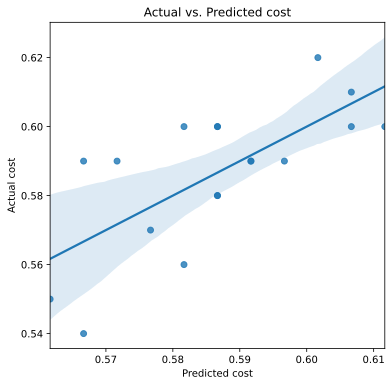

In [10]:
plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted cost')
plt.ylabel('Actual cost')
plt.title('Actual vs. Predicted cost')
plt.show()

So that's pretty good, but we seem to be missing interaction terms. In order to obtain those, we will want to add columns to our dataframe for each interaction. Statmodels technically has some built-in capability to do this, but I'm not convinced it properly centers the data.

In [11]:
Factors = ['lh', 'ps', 'id', 'rw', 'wt']
Interactions = [[p,q] for p in Factors for q in Factors]
InteractionsToUse = Interactions[1:5] + Interactions [7:10] + Interactions [13:15] + Interactions [23:24]
display(InteractionsToUse)

[['lh', 'ps'],
 ['lh', 'id'],
 ['lh', 'rw'],
 ['lh', 'wt'],
 ['ps', 'id'],
 ['ps', 'rw'],
 ['ps', 'wt'],
 ['id', 'rw'],
 ['id', 'wt'],
 ['wt', 'rw']]

In [12]:
# newDoE = swx1DoE.copy(deep=True)
InteractionTerms = []
for i in np.arange(len(InteractionsToUse)):
    InteractionTerms += [InteractionsToUse[i][0] + ' * ' + InteractionsToUse[i][1]]
    swx1DoE_actual[InteractionsToUse[i][0] + ' * ' + InteractionsToUse[i][1]] = (swx1DoE_actual[InteractionsToUse[i][0]]-swx1DoE_actual[InteractionsToUse[i][0]].mean()) * (swx1DoE_actual[InteractionsToUse[i][1]]-swx1DoE_actual[InteractionsToUse[i][1]].mean())
    
display(swx1DoE_actual[Factors + InteractionTerms])

,lh,ps,id,rw,wt,lh * ps,lh * id,lh * rw,lh * wt,ps * id,ps * rw,ps * wt,id * rw,id * wt,wt * rw
0,0.16,60.0,0.25,0.4,0.8,0.24,-2.000000e-03,8.000000e-03,0.008,-0.3,1.2,1.2,-1.000000e-02,-0.01,0.04
1,0.24,60.0,0.25,0.4,1.2,-0.24,2.000000e-03,-8.000000e-03,0.008,-0.3,1.2,-1.2,-1.000000e-02,0.01,-0.04
2,0.16,72.0,0.25,0.4,1.2,-0.24,-2.000000e-03,8.000000e-03,-0.008,0.3,-1.2,1.2,-1.000000e-02,0.01,-0.04
3,0.24,72.0,0.25,0.4,0.8,0.24,2.000000e-03,-8.000000e-03,-0.008,0.3,-1.2,-1.2,-1.000000e-02,-0.01,0.04
4,0.16,60.0,0.15,0.4,1.2,0.24,2.000000e-03,8.000000e-03,-0.008,0.3,1.2,-1.2,1.000000e-02,-0.01,-0.04
5,0.24,60.0,0.15,0.4,0.8,-0.24,-2.000000e-03,-8.000000e-03,-0.008,0.3,1.2,1.2,1.000000e-02,0.01,0.04
6,0.16,72.0,0.15,0.4,0.8,-0.24,2.000000e-03,8.000000e-03,0.008,-0.3,-1.2,-1.2,1.000000e-02,0.01,0.04
7,0.24,72.0,0.15,0.4,1.2,0.24,-2.000000e-03,-8.000000e-03,0.008,-0.3,-1.2,1.2,1.000000e-02,-0.01,-0.04
8,0.16,60.0,0.25,0.8,1.2,0.24,-2.000000e-03,-8.000000e-03,-0.008,-0.3,-1.2,-1.2,1.000000e-02,0.01,0.04
9,0.24,60.0,0.25,0.8,0.8,-0.24,2.000000e-03,8.000000e-03,-0.008,-0.3,-1.2,1.2,1.000000e-02,-0.01,-0.04


                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     9.467
Date:                Sat, 26 Jun 2021   Prob (F-statistic):             0.0996
Time:                        11:29:25   Log-Likelihood:                 83.366
No. Observations:                  18   AIC:                            -134.7
Df Residuals:                       2   BIC:                            -120.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5192      0.025     20.930      0.0

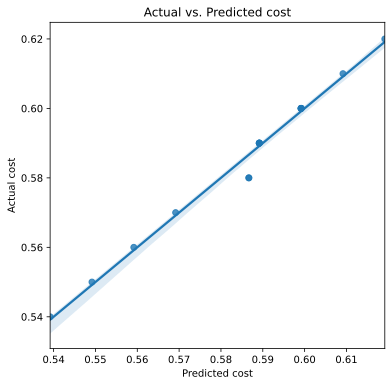

In [13]:
y = swx1DoE_actual['cost']
#y = swx1DoE_actual['time']
X = swx1DoE_actual[Factors + InteractionTerms]

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted cost')
plt.ylabel('Actual cost')
plt.title('Actual vs. Predicted cost')
plt.show()

This time our model is significantly _overfit_, and has too many terms! We need to [remove terms](https://en.wikipedia.org/wiki/Stepwise_regression), one at a time. We could write an algorithm to do it based on p-value thresholds, Log-Liklihood, AIC, or BIC (as far as I know, one isn't built into statsmodels). I'm not going to demonstrate that here, but jump right to the final model (optimized for BIC).

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     8.450
Date:                Sat, 26 Jun 2021   Prob (F-statistic):            0.00138
Time:                        11:29:25   Log-Likelihood:                 56.404
No. Observations:                  18   AIC:                            -102.8
Df Residuals:                      13   BIC:                            -98.36
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5192      0.016     32.905      0.0

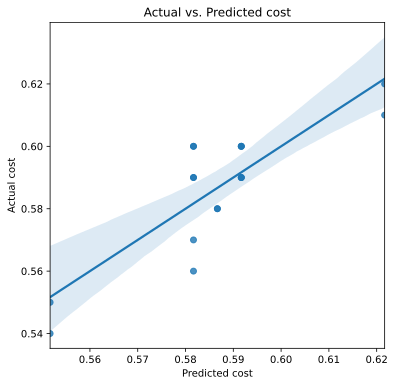

In [14]:
y = swx1DoE_actual['cost']
#y = swx1DoE_actual['time']
X = swx1DoE_actual[['id', 'rw', 'id * wt', 'wt * rw']]

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted cost')
plt.ylabel('Actual cost')
plt.title('Actual vs. Predicted cost')
plt.show()